<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/watbalance_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import ee
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# Initialize the session
ee.Initialize(project="ee-sakda-451407")

In [7]:
import ee
import pandas as pd

# จุดที่สนใจ (เชียงใหม่)
region = ee.Geometry.Point([99.0, 18.8])

# โหลดข้อมูล CHIRPS รายวัน และรวมรายเดือน
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2010-01-01', '2023-12-31') \
    .filterBounds(region) \
    .select('precipitation')

def create_monthly_images(year):
    year = ee.Number(year)
    months = ee.List.sequence(1, 12)
    def create_month(month):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')
        image = chirps.filterDate(start, end).sum().set('system:time_start', start.millis())
        return image
    return months.map(create_month)

years = ee.List.sequence(2010, 2023)
monthly = ee.ImageCollection(years.map(create_monthly_images).flatten())

# คำนวณค่าเฉลี่ยรายเดือนที่จุด
def image_to_feature(img):
    mean = ee.Image(img).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000
    )
    return ee.Feature(None, {
        'rainfall': mean.get('precipitation'),
        'date': ee.Image(img).date().format('YYYY-MM-dd')
    })

features = monthly.map(image_to_feature)

# ดึงข้อมูลลงมาเป็น pandas dataframe
fc = ee.FeatureCollection(features)
data = fc.getInfo()['features']
df = pd.DataFrame([{
    'date': f['properties']['date'],
    'rainfall': f['properties']['rainfall']
} for f in data])

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()


In [29]:
rain = df["rainfall"].fillna(0).values
dates = df.index.values  # ✅ ใช้ .index แทน df['date']

# Normalize
scaler = MinMaxScaler()
rain = scaler.fit_transform(rain.reshape(-1, 1))

print(rain[:5])
print(dates[:5])

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rain = scaler.fit_transform(rain.reshape(-1, 1))

def create_sequences(data, seq_len):
  X,y = [],[]
  for i in range(len(data)-seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])
  return np.array(X), np.array(y)

sequence_length = 12
X,y = create_sequences(rain, sequence_length)

[[0.01886474]
 [0.        ]
 [0.03683462]
 [0.05712919]
 [0.24843382]]
['2010-01-01T00:00:00.000000000' '2010-02-01T00:00:00.000000000'
 '2010-03-01T00:00:00.000000000' '2010-04-01T00:00:00.000000000'
 '2010-05-01T00:00:00.000000000']


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0992 - val_loss: 0.1051
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0831 - val_loss: 0.0923
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0627 - val_loss: 0.0807
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0597 - val_loss: 0.0708
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0603 - val_loss: 0.0635
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0530 - val_loss: 0.0603
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0563 - val_loss: 0.0599
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0538 - val_loss: 0.0592
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0550 - val_loss: 0.0589
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0489 - val_loss: 0.0593
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0470 - val_loss: 0.0593
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0508 - val_loss: 0.0585


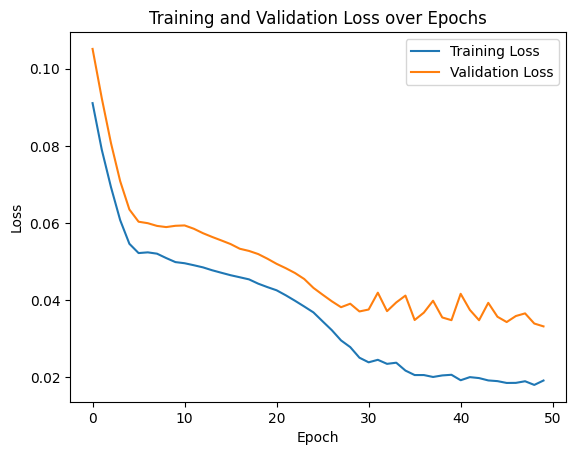

In [33]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [35]:
# Make predictions for the next month
future_sequence = rain[-sequence_length:].reshape(1, sequence_length, 1)
print(future_sequence)
predicted_scaled = model.predict(future_sequence)
predicted_rainfall = scaler.inverse_transform(predicted_scaled)[0][0]

print(f"Predicted rainfall for the next month: {predicted_rainfall:.2f} mm")


[[[0.        ]
  [0.02027323]
  [0.05903843]
  [0.05328644]
  [0.40352995]
  [0.26523346]
  [0.27636028]
  [0.26740447]
  [0.51092491]
  [0.57653997]
  [0.03112356]
  [0.01601005]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted rainfall for the next month: 0.03 mm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted rainfall for the next year:
2024-01-01: 0.03 mm
2024-02-01: 0.04 mm
2024-03-01: 0.07 mm
2024-04-01: 0.13 mm
2024-05-01: 0.22 mm
2024-06-01: 0.25 mm
2024-07-01: 0.31 mm
2024-08-01: 0.37 mm
2024-09-01: 0.45 mm
2024-10-01: 0.38 mm
2024-11-01: 0.10 mm
2024-12-01: 0.05 mm


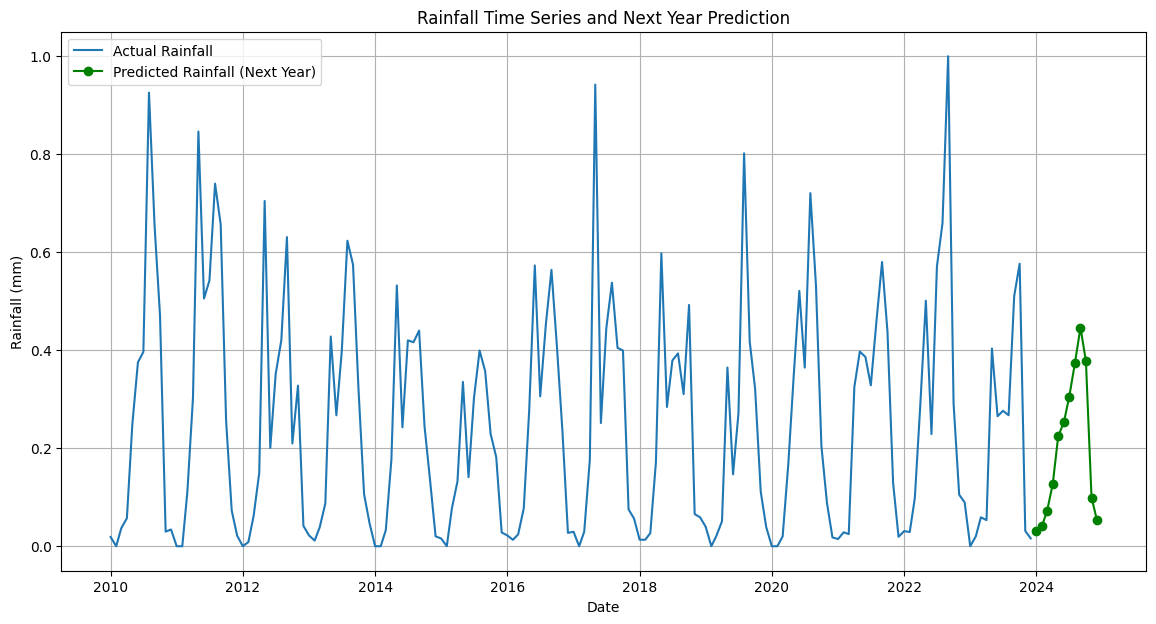

In [36]:
# Extend the dates to cover the next year (12 months)
last_date = pd.to_datetime(dates[-1])
future_dates = pd.date_range(start=last_date, periods=13, freq='MS')[1:] # Start from the month *after* the last date, include 12 months

# Prepare the initial sequence for prediction (the last sequence from the training data)
current_sequence = rain[-sequence_length:].reshape(1, sequence_length, 1)

# List to store future predictions
future_predictions_scaled = []

# Predict the next 12 months
for _ in range(12):
  predicted_scaled_next = model.predict(current_sequence)
  future_predictions_scaled.append(predicted_scaled_next[0][0])

  # Update the current sequence by removing the first element and adding the new prediction
  current_sequence = np.append(current_sequence[:, 1:, :], predicted_scaled_next.reshape(1, 1, 1), axis=1)

# Inverse transform the scaled predictions
predicted_rainfall_next_year = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

# Print the predictions
print("\nPredicted rainfall for the next year:")
for date, rainfall in zip(future_dates, predicted_rainfall_next_year):
  print(f"{date.strftime('%Y-%m-%d')}: {rainfall:.2f} mm")


# Prepare data for the chart
# Create a series for actual rainfall
actual_series = pd.Series(scaler.inverse_transform(rain).flatten(), index=pd.to_datetime(dates))

# Create a series for the predicted rainfall for the next year
predicted_series_next_year = pd.Series(predicted_rainfall_next_year, index=future_dates)

# Combine actual and predicted for plotting
combined_series_next_year = pd.concat([actual_series, predicted_series_next_year])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(actual_series.index, actual_series.values, label='Actual Rainfall')
plt.plot(predicted_series_next_year.index, predicted_series_next_year.values, 'go-', label='Predicted Rainfall (Next Year)') # 'go-' for green circle marker and line
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Time Series and Next Year Prediction')
plt.legend()
plt.grid(True)
plt.show()